Columns in *.csv file                   Format
----------------------------------------------------------------------------------------------------------------------------------------------------
1.    Timestamp                         Timestamp from the AIS basestation, format: 31/12/2015 23:59:59 

2.    Type of mobile                    Describes what type of target this message is received from (class A AIS Vessel, Class B AIS vessel, etc)

3.    MMSI                              MMSI number of vessel

4.    Latitude                          Latitude of message report (e.g. 57,8794)

5.    Longitude                         Longitude of message report (e.g. 17,9125)

6.    Navigational status               Navigational status from AIS message if available, e.g.: 'Engaged in fishing', 'Under way using engine', mv.

7.    ROT                               Rot of turn from AIS message if available

8.    SOG                               Speed over ground from AIS message if available

9.    COG                               Course over ground from AIS message if available

10.   Heading                           Heading from AIS message if available

11.   IMO                               IMO number of the vessel

12.   Callsign                          Callsign of the vessel 

13.   Name                              Name of the vessel

14.   Ship type                         Describes the AIS ship type of this vessel 

15.   Cargo type                        Type of cargo from the AIS message 

16.   Width                             Width of the vessel

17.   Length                            Lenght of the vessel 

18.   Type of position fixing device    Type of positional fixing device from the AIS message 

19.   Draught                           Draugth field from AIS message

20.   Destination                       Destination from AIS message

21.   ETA                               Estimated Time of Arrival, if available  

22.   Data source type                  Data source type, e.g. AIS

23.   Size A                            Length from GPS to the bow

24.   Size B                            Length from GPS to the stern

25.   Size C                            Length from GPS to starboard side

26.   Size D                            Length from GPS to port side





In [24]:
import pandas as pd
import pyarrow
import pyarrow.parquet

In [31]:
def fn(file_path, out_path):
    dtypes = {
        "MMSI": "object",
        "SOG": float,
        "COG": float,
        "Longitude": float,
        "Latitude": float,
        "# Timestamp": "object",
        "Type of mobile": "object",
        "Destination": "object",
        "Cargo Type": "object",
    }
    usecols = list(dtypes.keys())
    df = pd.read_csv(file_path, usecols=usecols, dtype=dtypes)

    # Remove errors
    bbox = [60, 0, 50, 20]
    north, west, south, east = bbox
    df = df[(df["Latitude"] <= north) & (df["Latitude"] >= south) & (df["Longitude"] >= west) & (
            df["Longitude"] <= east)]

    df = df[df["Type of mobile"].isin(["Class A", "Class B"])].drop(columns=["Type of mobile"])
    df = df[df["MMSI"].str.len() == 9]  # Adhere to MMSI format
    df = df[df["MMSI"].str[:3].astype(int).between(200, 775)]  # Adhere to MID standard

    df = df.rename(columns={"# Timestamp": "Timestamp"})
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%d/%m/%Y %H:%M:%S", errors="coerce")

    df = df.drop_duplicates(["Timestamp", "MMSI", ], keep="first")

    def track_filter(g):
        len_filt = len(g) > 256  # Min required length of track/segment
        sog_filt = 1 <= g["SOG"].max() <= 50  # Remove stationary tracks/segments
        time_filt = (g["Timestamp"].max() - g["Timestamp"].min()).total_seconds() >= 60 * 60  # Min required timespan
        return len_filt and sog_filt and time_filt

    # Track filtering
    df = df.groupby("MMSI").filter(track_filter)
    df = df.sort_values(['MMSI', 'Timestamp'])

    # Divide track into segments based on timegap
    df['Segment'] = df.groupby('MMSI')['Timestamp'].transform(
        lambda x: (x.diff().dt.total_seconds().fillna(0) >= 15 * 60).cumsum())  # Max allowed timegap

    # Segment filtering
    df = df.groupby(["MMSI", "Segment"]).filter(track_filter)
    df = df.reset_index(drop=True)

    #
    knots_to_ms = 0.514444
    df["SOG"] = knots_to_ms * df["SOG"]

    # Clustering
    # kmeans = KMeans(n_clusters=48, random_state=0)
    # kmeans.fit(df[["Latitude", "Longitude"]])
    # df["Geocell"] = kmeans.labels_
    # centers = kmeans.cluster_centers_
    # "Latitude": center[0],
    # "Longitude": center[1],

    # df["Date"] = df["Timestamp"].dt.strftime("%Y-%m-%d")
    # Save as parquet file with partitions
    table = pyarrow.Table.from_pandas(df, preserve_index=False)
    pyarrow.parquet.write_to_dataset(
        table,
        root_path=out_path,
        partition_cols=["MMSI",  # "Date",
                        "Segment",  # "Geocell"
                        ]
    )



In [32]:


path = "data/aisdk-2025-02-27.csv"
out_path = "data/parquet/"


In [33]:
fn(path, out_path)

ValueError: Usecols do not match columns, columns expected but not found: ['Cargo Type']

In [30]:
df = pd.read_parquet(out_path)

df

,Timestamp,Latitude,Longitude,SOG,COG,Destination,MMSI,Segment
0,2025-02-27 00:00:05,56.123522,11.591552,6.739216,90.1,Unknown,200000000,0
1,2025-02-27 00:00:06,56.123522,11.591770,6.739216,90.0,Unknown,200000000,0
2,2025-02-27 00:00:07,56.123522,11.591770,6.739216,90.0,Unknown,200000000,0
3,2025-02-27 00:00:13,56.123518,11.592530,6.739216,89.8,Unknown,200000000,0
4,2025-02-27 00:00:14,56.123518,11.592637,6.739216,89.7,Unknown,200000000,0
...,...,...,...,...,...,...,...,...
13692441,2025-02-27 23:58:39,56.966058,7.783942,6.327661,212.2,None,677088500,0
13692442,2025-02-27 23:58:59,56.965090,7.782812,6.327661,212.4,None,677088500,0
13692443,2025-02-27 23:59:09,56.964605,7.782242,6.327661,212.3,None,677088500,0
13692444,2025-02-27 23:59:30,56.963595,7.781062,6.327661,212.9,None,677088500,0


In [ ]:
df["Destination"].value_counts()

Time stamp: date and time

Latitude: breddegrad

Longitude: længdegrad

SOG: Speed Over Ground

COG: Course Over Ground

MMSI: Maritime Mobile Service Identity (ID pretty much)

Segment: ???

In [17]:
# Basic stats
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6846223 entries, 0 to 6846222
Data columns (total 7 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Timestamp  datetime64[ns]
 1   Latitude   float64       
 2   Longitude  float64       
 3   SOG        float64       
 4   COG        float64       
 5   MMSI       category      
 6   Segment    category      
dtypes: category(2), datetime64[ns](1), float64(4)
memory usage: 280.8 MB
None


In [9]:
print(df.describe())


                           Timestamp      Latitude     Longitude  \
count                        6614370  6.614370e+06  6.614370e+06   
mean   2025-02-28 12:16:35.549011968  5.609576e+01  1.081220e+01   
min              2025-02-28 00:00:00  5.383878e+01  2.600000e-04   
25%              2025-02-28 06:36:25  5.509747e+01  9.541996e+00   
50%              2025-02-28 12:26:53  5.589325e+01  1.088654e+01   
75%              2025-02-28 18:00:55  5.714674e+01  1.218605e+01   
max              2025-02-28 23:59:58  5.942874e+01  1.724252e+01   
std                              NaN  1.135892e+00  2.244197e+00   

                SOG           COG  
count  6.609961e+06  6.471976e+06  
mean   3.810081e+00  1.783375e+02  
min    0.000000e+00  0.000000e+00  
25%    5.144440e-02  8.300000e+01  
50%    4.064108e+00  1.860000e+02  
75%    6.070439e+00  2.629000e+02  
max    2.330431e+01  3.599000e+02  
std    3.456403e+00  1.040601e+02  


In [18]:
print(f"Total records: {len(df)}")
print(f"Unique vessels: {df['MMSI'].nunique()}")
print(f"Date range: {df['Timestamp'].min()} to {df['Timestamp'].max()}") # for the entire day
print(f"Unique segments: {df.groupby(['MMSI', 'Segment']).ngroups}")

Total records: 6846223
Unique vessels: 1356
Date range: 2025-02-27 00:00:00 to 2025-02-27 23:59:58
Unique segments: 1611


/var/folders/6x/jpylqzgs1yq2q_xtb9dv1lym0000gn/T/ipykernel_5109/2704259542.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(f"Unique segments: {df.groupby(['MMSI', 'Segment']).ngroups}")


In [19]:
print(f"Taking a look at a random vessel's segments: {df['MMSI'].sample().values}")

Taking a look at a random vessel's segments: [219005732]
Categories (1356, int32): [200000000, 200000001, 203247191, 205210000, ..., 668116306, 668116311, 677083800, 677088500]


/var/folders/6x/jpylqzgs1yq2q_xtb9dv1lym0000gn/T/ipykernel_5109/1322746196.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for segment_id, segment in vessel_data.groupby('Segment'):
/var/folders/6x/jpylqzgs1yq2q_xtb9dv1lym0000gn/T/ipykernel_5109/1322746196.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for segment_id, segment in vessel_data.groupby('Segment'):


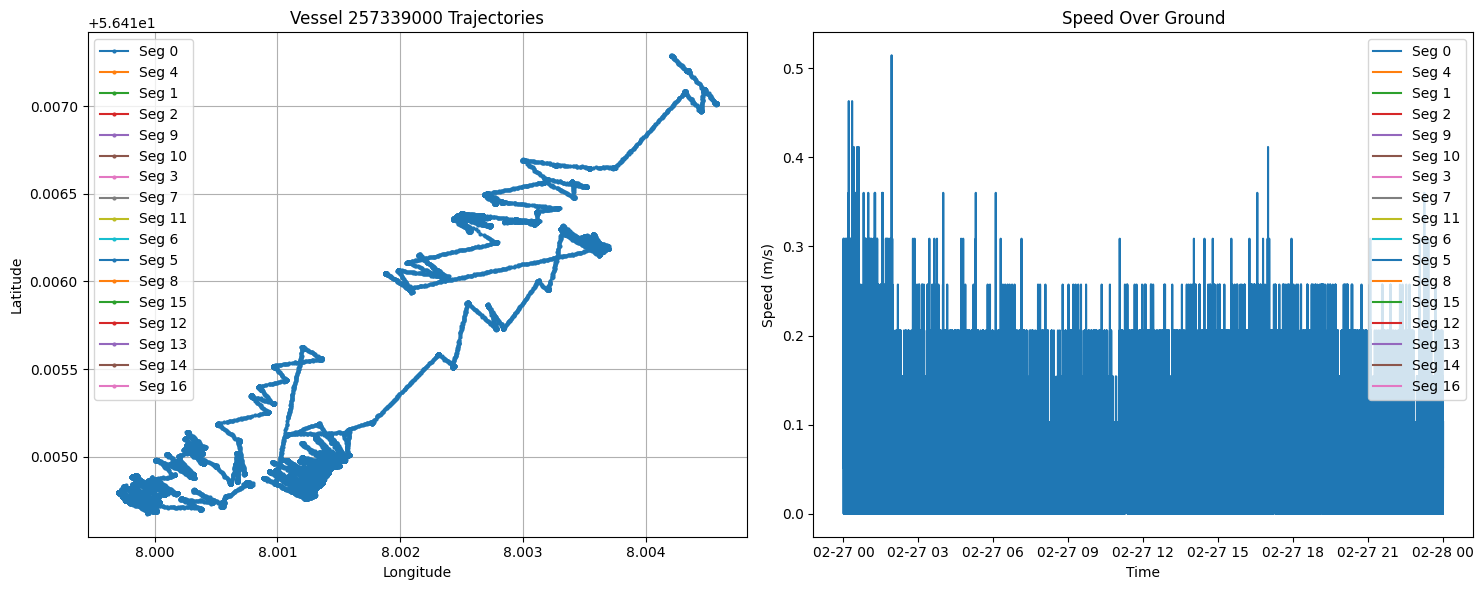

In [20]:
import matplotlib.pyplot as plt

# Pick one vessel with multiple segments
sample_mmsi = df['MMSI'].value_counts().index[0] # takes the first most frequent MMSI
vessel_data = df[df['MMSI'] == sample_mmsi]

# Plot all segments for this vessel
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Geographic plot
for segment_id, segment in vessel_data.groupby('Segment'):
    axes[0].plot(segment['Longitude'], segment['Latitude'], 
                 marker='o', markersize=2, label=f'Seg {segment_id}')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title(f'Vessel {sample_mmsi} Trajectories')
axes[0].legend()
axes[0].grid(True)

# Speed over time
for segment_id, segment in vessel_data.groupby('Segment'):
    axes[1].plot(segment['Timestamp'], segment['SOG'], label=f'Seg {segment_id}')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Speed (m/s)')
axes[1].set_title('Speed Over Ground')
axes[1].legend()
plt.tight_layout()
plt.show()

In [21]:
# Segment statistics
segment_stats = df.groupby(['MMSI', 'Segment']).agg({
    'Timestamp': ['min', 'max', 'count'],
    'Latitude': ['min', 'max'],
    'Longitude': ['min', 'max'],
    'SOG': ['mean', 'max'],
    'COG': 'mean'
}).reset_index()

segment_stats.columns = ['_'.join(col).strip('_') for col in segment_stats.columns]
segment_stats['duration_hours'] = (
    (segment_stats['Timestamp_max'] - segment_stats['Timestamp_min']).dt.total_seconds() / 3600
)

print(segment_stats.head())
print(f"\nAverage segment length: {segment_stats['Timestamp_count'].mean():.0f} points")
print(f"Average duration: {segment_stats['duration_hours'].mean():.1f} hours")

/var/folders/6x/jpylqzgs1yq2q_xtb9dv1lym0000gn/T/ipykernel_5109/1627486484.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_stats = df.groupby(['MMSI', 'Segment']).agg({


        MMSI Segment       Timestamp_min       Timestamp_max  Timestamp_count  \
0  200000000       0 2025-02-27 00:00:05 2025-02-27 20:49:00            22541   
1  200000000       4                 NaT                 NaT                0   
2  200000000       1                 NaT                 NaT                0   
3  200000000       2                 NaT                 NaT                0   
4  200000000       9                 NaT                 NaT                0   

   Latitude_min  Latitude_max  Longitude_min  Longitude_max  SOG_mean  \
0      55.98748     56.321773      11.064208      11.870603   6.26677   
1           NaN           NaN            NaN            NaN       NaN   
2           NaN           NaN            NaN            NaN       NaN   
3           NaN           NaN            NaN            NaN       NaN   
4           NaN           NaN            NaN            NaN       NaN   

    SOG_max    COG_mean  duration_hours  
0  8.128215  181.401965       20